Mega-Amp Spherical Tokamak
==========================

An example of a dead start (from scratch) for the MAST tokamak. A solution to the Grad-Shafranov equation requires 

1. A definition of the locations of the poloidal field coils, and how they are wired together, for example connected in series to the same power supplies. This is specific to the machine.
2. Plasma profiles of pressure and current, p(psi) and f(psi), together with global contraints such as total plasma current, which indirectly specify the size of the plasma.
3. A control system which sets the shape and location of the plasma. Like a real plasma, feedback control is needed to stabilise vertical and radial motion in free-boundary Grad-Shafranov solvers.


In [1]:
# Step 1: Specify the locations of the coils, and the domain you want to solve over

from freegs import machine
from freegs.equilibrium import Equilibrium

# Define the poloidal field coil set
tokamak = machine.MAST()

# Define the domain to solve over
eq = Equilibrium(tokamak=tokamak,
                 Rmin=0.1, Rmax=2.0,    # Radial domain
                 Zmin=-2.0, Zmax=2.0,   # Height range
                 nx=65, ny=65)        # Number of grid points

Define toroidal current function. The RHS of the Grad-Shafranov equation is determined by the toroidal current density

$j_{tor} = -R\frac{\partial p}{\partial \psi} - \frac{1}{\mu_0 R}f\frac{\partial p}{\partial \psi}$

The profiles can be adjusted to match global constrants, such as the pressure on axis and the total plasma current $I_p$

The toroidal current function jtor_func calculates the toroidal current density $j_{tor}$ given $\psi$ on an R-Z mesh

In [2]:
# Step 2: Specify the profiles of pressure and f=R*Bt. 
# Currently quite simple functions are supported

from freegs.jtor import ConstrainPaxisIp

profiles = ConstrainPaxisIp(3e3, # Plasma pressure on axis [Pascals]
                            7e5, # Plasma current [Amps]
                            0.4) # vacuum f = R*Bt

In [3]:
# Step 3: Specify the control system and feedback variables.
# The control system adjusts the currents in the poloidal field coils
# to produce X-points in the desired locations, and ensure that the desired
# pairs of locations have the same poloidal flux.

from freegs import control

xpoints = [(0.7, -1.1),   # (R,Z) locations of X-points
           (0.7, 1.1)]

# Contstrain these pairs of (R,Z, R,Z) locations to have the same poloidal flux
# This is needed for radial and vertical position control of the plasma.
isoflux = [(0.7,-1.1, 1.45, 0.0)   # Lower X-point, Outboard midplane
           ,(0.7,1.1, 1.45, 0.0)   # Upper X-point, Outboard midplane
          ]

constrain = control.constrain(xpoints=xpoints, gamma=1e-12, isoflux=isoflux)

constrain(eq)

Current changes: [  199040.   194436.  -851152.  -850832.  -349872.  -350192.   -19776.
   -19712.  -395200.  -395008. -1421964.]


In [4]:
# With these three components (coils, profiles and constraints), solve the nonlinear
# system with a Picard iteration. This modifies the "eq" object.

from freegs import picard

picard.solve(eq,           # The equilibrium to adjust
             profiles,     # The toroidal current profile function
             constrain)    # Constraint function to set coil currents

Current changes: [-2244.83349609  2213.09765625   295.55273438  -237.66503906
  -412.11083984   438.34570312   177.04003906  -156.56542969
   106.86132812   -67.3671875    110.88916016]
Constraints: L = 1.492411e+06, Beta0 = 1.737273e-02
Maximum change in psi: 8.136527e-01. Relative: 5.796409e-01
Current changes: [-180404. -176520.  858960.  858736.  310560.  310816. -123744. -123744.
  329152.  328960. 1313176.]
Constraints: L = 1.952993e+06, Beta0 = 4.426211e-02
Maximum change in psi: 1.310159e-02. Relative: 4.233669e-02
Current changes: [  281.25     -3402.96875   9342.625     9954.625     2368.8125
  1602.25     -6293.5      -6289.375     1432.5       1302.
 12261.140625]
Constraints: L = 2.157291e+06, Beta0 = 3.528948e-02
Maximum change in psi: 4.515810e-03. Relative: 1.399561e-02
Current changes: [ -545.828125   -615.4296875  3104.75       2888.3125      908.5625
   953.3125    -1088.875      -766.625       755.75       1070.
  4349.6171875]
Constraints: L = 2.238889e+06, Beta0 =

In [5]:
print("Plasma current: %e Amps" % (eq.plasmaCurrent()))

Plasma current: 7.000000e+05 Amps


In [6]:
tokamak.printCurrents()

P2U : Coil(R=0.49,Z=1.76,current=15775.375732421875,control=True)
P2L : Coil(R=0.49,Z=-1.76,current=15765.599609375,control=True)
P3U : Coil(R=1.1,Z=1.1,current=20879.669921875,control=True)
P3L : Coil(R=1.1,Z=-1.1,current=20867.8271484375,control=True)
P4U : Coil(R=1.51,Z=1.095,current=-35530.14208984375,control=True)
P4L : Coil(R=1.51,Z=-1.095,current=-35477.076171875,control=True)
P5U : Coil(R=1.66,Z=0.52,current=-148162.0146484375,control=True)
P5L : Coil(R=1.66,Z=-0.52,current=-148151.9482421875,control=True)
P6U : Coil(R=1.5,Z=0.9,current=-62357.607421875,control=True)
P6L : Coil(R=1.5,Z=-0.9,current=-62396.0859375,control=True)
P1 : Solenoid(R=0.15,Zmin=-1.4,Zmax=1.4,current=-89933.05224609375,N=100,control=True)


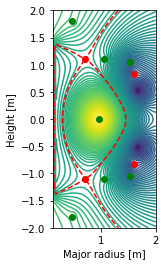

In [7]:
%matplotlib inline

from freegs.plotting import plotEquilibrium
plotEquilibrium(eq)

Modifying the equilibrium
-------------------------

Modify the constraints for the X-point locations and isoflux pairs. Starting from the previous solution, this quite quickly finds a new solution.

Current changes: [  35470.5        35509.5        49456.         49461.625
  -27338.        -27347.         31559.890625   31557.484375
 -100381.       -100387.75      -28702.      ]


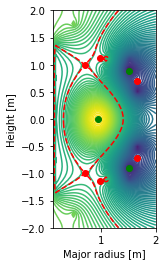

In [8]:
xpoints = [(0.7, -1.0),   # (R,Z) locations of X-points
           (0.7, 1.0)]

isoflux = [(0.7,-1.0, 1.4, 0.0),(0.7,1.0, 1.4, 0.0), (0.7,-1.0, 0.3, 0.0)]

constrain = control.constrain(xpoints=xpoints, gamma=1e-12, isoflux=isoflux)

constrain(eq)

plotEquilibrium(eq)

In [9]:
picard.solve(eq,           # The equilibrium to adjust
             profiles,    # The toroidal current profile function
             constrain)    # Constraint function to set coil currents

Current changes: [ 19.79418182 -18.40817261  -1.52194977   2.53163242   2.44516754
  -3.38001633  -0.97712708   2.41149902  -3.37715149   0.12913513
  -1.67303085]
Constraints: L = 2.472962e+06, Beta0 = 3.106158e-02
Maximum change in psi: 4.838777e-03. Relative: 1.390760e-02
Current changes: [-12561.4375   -12576.75     -23173.1875   -23174.28125   10147.875
  10150.5      -15456.625    -15455.375     40013.75      40014.625
  -8797.796875]
Constraints: L = 2.514158e+06, Beta0 = 2.904366e-02
Maximum change in psi: 1.902966e-03. Relative: 5.810260e-03
Current changes: [-2030.3125     -2020.140625   -4768.359375   -4770.2890625
  1686.9375      1690.125      -1223.9453125  -1224.02734375
  6820.71875     6820.5625     -2241.25585938]
Constraints: L = 2.519348e+06, Beta0 = 2.880003e-02
Maximum change in psi: 1.085435e-03. Relative: 3.322851e-03
Current changes: [ -571.8828125   -570.1640625  -1737.5625     -1737.62890625
   515.59375      516.25         204.37890625   203.65429688
  2091.

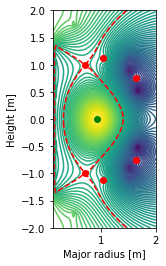

In [10]:
plotEquilibrium(eq)